Quantum embedding shape: (120, 4)
Original feature shape: (120, 4)

PCA explained variance ratio: [0.74904959 0.18644327]
Total variance explained: 93.55%

Visualization saved as 'embedding_analysis.png'

--- Classification Results ---
Quantum embedding accuracy: 73.33%
Original features accuracy: 93.33%

--- Embedding Statistics ---
Quantum embedding mean: [0.59395136 0.34467255 0.26964964 0.21192201]
Quantum embedding std: [0.42817539 0.44193713 0.3219279  0.30361019]
Quantum embedding range: [-0.988, 1.000]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


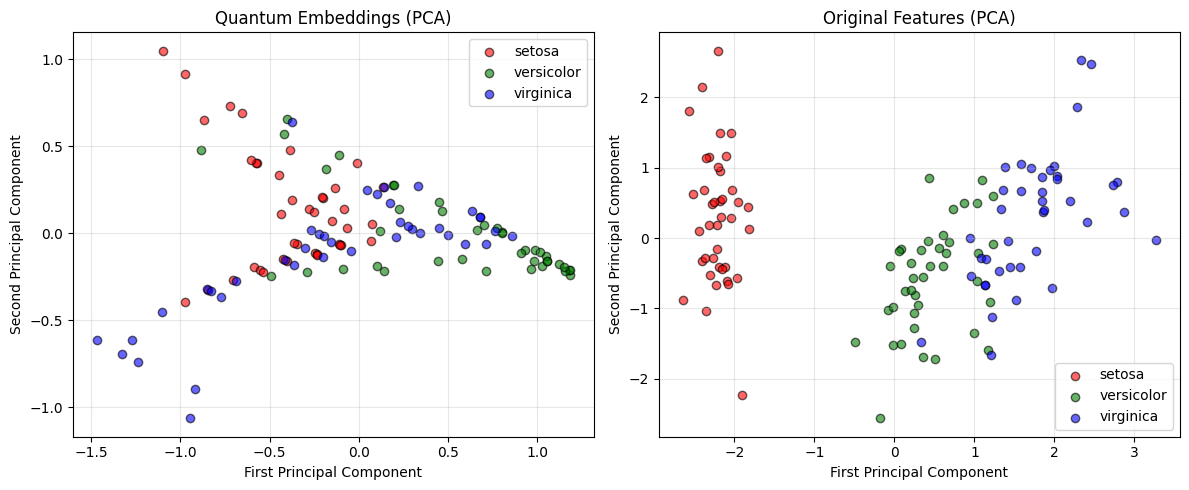

In [1]:
import pennylane as qml
from pennylane import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load iris data
iris = datasets.load_iris()
X = iris.data  # shape (150, 4)
y = iris.target  # 0,1,2

# Simple train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Quantum setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)

def circuit(params, x=None):
    feature_map(x)
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

@qml.qnode(dev)
def quantum_embedding(x, params):
    return circuit(params, x)

def make_embeddings(X, params):
    emb = []
    for x in X:
        emb.append(quantum_embedding(x, params))
    return np.array(emb)

# Initialize params
np.random.seed(0)
params = np.random.uniform(low=-0.5, high=0.5, size=(n_qubits,))

# Generate quantum embeddings
X_train_emb = make_embeddings(X_train_scaled, params)
X_test_emb = make_embeddings(X_test_scaled, params)

print("Quantum embedding shape:", X_train_emb.shape)
print("Original feature shape:", X_train_scaled.shape)

# Apply PCA to quantum embeddings
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_emb)
X_test_pca = pca.transform(X_test_emb)

print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Visualize embeddings in 2D
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    mask = y_train == i
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                c=color, label=iris.target_names[i], alpha=0.6, edgecolors='k')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Quantum Embeddings (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)

# For comparison: PCA on original features
pca_orig = PCA(n_components=2)
X_train_orig_pca = pca_orig.fit_transform(X_train_scaled)

plt.subplot(1, 2, 2)
for i, color in enumerate(colors):
    mask = y_train == i
    plt.scatter(X_train_orig_pca[mask, 0], X_train_orig_pca[mask, 1], 
                c=color, label=iris.target_names[i], alpha=0.6, edgecolors='k')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Original Features (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('embedding_analysis.png', dpi=150)
print("\nVisualization saved as 'embedding_analysis.png'")

# Train classifier on quantum embeddings
clf_quantum = LogisticRegression(max_iter=200, multi_class="auto")
clf_quantum.fit(X_train_emb, y_train)
y_pred_quantum = clf_quantum.predict(X_test_emb)
acc_quantum = accuracy_score(y_test, y_pred_quantum)

# Train classifier on original features for comparison
clf_orig = LogisticRegression(max_iter=200, multi_class="auto")
clf_orig.fit(X_train_scaled, y_train)
y_pred_orig = clf_orig.predict(X_test_scaled)
acc_orig = accuracy_score(y_test, y_pred_orig)

print(f"\n--- Classification Results ---")
print(f"Quantum embedding accuracy: {acc_quantum*100:.2f}%")
print(f"Original features accuracy: {acc_orig*100:.2f}%")

# Analyze embedding statistics
print(f"\n--- Embedding Statistics ---")
print(f"Quantum embedding mean: {np.mean(X_train_emb, axis=0)}")
print(f"Quantum embedding std: {np.std(X_train_emb, axis=0)}")
print(f"Quantum embedding range: [{np.min(X_train_emb):.3f}, {np.max(X_train_emb):.3f}]")
